# Shedding light on the effects of loadshedding in Cape Town

Loadshedding, an emergency method employed by Eskom for all of South Africa due to the ongoing energy crisis.
South Africans all across the country have to deal with the stark reality of having their power from the national energy supplier be cut off for multiple hours a day.
In fact, according to [BusinessTech](https://businesstech.co.za/news/business-opinion/681001/from-bad-to-worse-load-shedding-vs-blackout-hours-in-south-africa/), South Africans were without power for roughly 6 hours per day for the first few months of this year.
However, are there any hidden causes and effects behind this? (Your washing being delayed doesn't count.)

We'll examine some pertinent questions, first the mechanics and the extent to which loadshedding has been affecting our lives.
Then, the question we wish we didn't have to ask: Is loadshedding actually effective?
A couple of jabs are made at some darker topics, questioning if loadshedding has had an impact on crime and mortality, before lightening up by looking at South Africa's transition to renewable power, and any hope that may be in sight. 

Before we get into the questions, let's consider the data we'll use.
Below are descriptions of the data sets, presented in a herirachicacal structure resembling the filesystem.

***
**loadshedding/**
- `national.csv` A CSV file of [ESP's Loadshedding History Spreadsheet](https://docs.google.com/spreadsheets/d/1ZpX_twP8sFBOAU6t--Vvh1pWMYSvs60UXINuD5n-K08/).
- `cape_town.csv` Converted CSV file from the City of Cape Town's [Loadshedding History](https://odp-cctegis.opendata.arcgis.com/documents/cctegis::load-shedding/explore).
- `Load_shedding_Blocks.geojson` A GeoJSON file of Cape Town [Load shedding Blocks](https://odp-cctegis.opendata.arcgis.com/datasets/10660842ff274c5f90977dc53e9ff804_111/about)

**billing/** Downloaded from The City of Cape Town [Electricity Billing](https://www.arcgis.com/home/item.html?id=04bc3dcbc2ea4ca58ec26f4ec5a361ef) data.
Had to download each year separately and convert from excel to CSV. Renamed all files from "Electricity Billing January 2022" to "2022-01" format. 

**load/** Downloaded from the the City of Cape Town [Electricity Load Profile](https://odp-cctegis.opendata.arcgis.com/documents/electricity-load-profile/about). CSVs combined from each of the area's `csv/` folder.

**emissions/**
- `Emissions_By_Sector_In_tCO2e.csv` Extracted from the City of Cape Town's [State of Energy and Carbon](https://odp-cctegis.opendata.arcgis.com/documents/cpt-state-of-energy-and-carbon-2021/about).
- `Energy_Per_Sector_In_GJ.csv` Extracted from the City of Cape Town's [State of Energy and Carbon](https://odp-cctegis.opendata.arcgis.com/documents/cpt-state-of-energy-and-carbon-2021/about).

<div class="alert alert-block alert-info">
    Emissions and Energy per sector were in the sheet "Tables" at A86:J113 from the State of Energy and Carbon. These were from the Outputs Database in the `Data/` folder.
</div>

**crime_statistics_for_south_africa/** 
- `station_boundaries/` A collection of spatial data formats of SAPS [Policing boundaries/station points](https://www.saps.gov.za/services/boundary.php)
- `SAPS_data/all_SAPS_data.csv` A CSV file containing compiled [National crime data](https://www.saps.gov.za/services/older_crimestats.php)

**mortality/** 

- `daily_death_counts.csv` Computed using `src/count_mortalities.py`, `src/get_total_counts.py`, and the [Mortality and Causes of Death 1997-2018](https://www.datafirst.uct.ac.za/dataportal/index.php/catalog/830/data-dictionary) data set.
- `population_counts.csv` Yearly population counts, downloaded from [MacroTrends](https://www.macrotrends.net/countries/ZAF/south-africa/population).

***

First, import the libraries required by this notebook. We use [Pandas](https://pandas.pydata.org/), as the industry standard for data science in Python.

In [1]:
from glob import glob
from pathlib import Path
from areas import MAPPINGS
import matplotlib.pyplot as plt
from functools import partial
from scipy.stats import ttest_ind, levene, pearsonr, ttest_ind_from_stats
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import warnings
import mortality_utils
import crime_utils
import math

## Is loadshedding getting worse?

Loadshedding has plagued South Africa since 2007. However, the City of Cape Town only provides loadshedding data from 2018. Import, transform and visualise these data as shown below. You may impute the four missing `Duration min` values using the mean duration, since the mean duration is equal for all stages, the variance is small and there are few missing values.

It is perhaps surprising to find that the mean loadshedding duration is equal for all stages, since stage 6 includes four-hour blocks. However, the data set represents four-hour blocks as two two-hour back-to-back blocks.

In [2]:
# read the data stored in a CSV to a Pandas DataFrame
loadshedding = pd.read_csv("../data/loadshedding/cape_town.csv", delimiter=";")
loadshedding = loadshedding.drop("Unnamed: 5", axis=1)
loadshedding.rename(columns={"Area ": "Area"}, inplace=True)
# transform the seperate date and time features to DateTime
loadshedding["Start"] = pd.to_datetime(loadshedding["Date"] + "T" + loadshedding["Time"], format="mixed")
# convert Minutes to numerical values
loadshedding["Minutes"] = loadshedding["Duration min"].astype(float)
# impute the four missing 'Minutes' values with the mean duration in minutes
loadshedding["Minutes"] = loadshedding["Minutes"].fillna(value=loadshedding["Minutes"].mean())
loadshedding["End"] = loadshedding.apply(lambda row: row["Start"] + pd.Timedelta(minutes=row["Minutes"]), axis=1)
loadshedding.drop(columns={"Date", "Time", "Duration min"}, inplace=True)

Loadshedding-minutes are calculated as the sum of loadshedding duration (in minutes) experienced by affected areas. Let's consider the suburbs of Cape Town and a 24-hour time period. The summary statistics of loadshedding-minutes per day in Cape Town are plotted, per stage, below. The violin plots indicate an (intuitive) increase in mean loadshedding-minutes and decrease in variance as the stage increases. This decrease in variance can be ascribed to less time spent during the higher stages and therefore less anomalies occuring in the power grid.

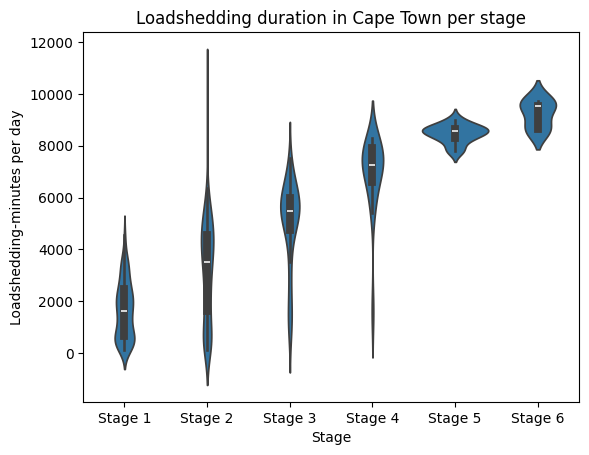

In [3]:
# discard inconsistent data pre February 2020
consistent_loadshedding = loadshedding[loadshedding["Start"] >= pd.to_datetime("2020/2/1")]
# group the instances of loadshedding by day, summing the duration
consistent_loadshedding_per_day = consistent_loadshedding.groupby(
    pd.Grouper(key="Start", freq="d")).agg(
        Stage=pd.NamedAgg(column="Stage", aggfunc="min"),
        Minutes=pd.NamedAgg(column="Minutes", aggfunc="sum")).sort_values("Stage")
# create a violin plot
sns.violinplot(data=consistent_loadshedding_per_day, x="Stage", y="Minutes")
plt.ylabel("Loadshedding-minutes per day")
plt.title("Loadshedding duration in Cape Town per stage")
plt.show()

The distribution of instances of loadshedding in Cape Town, per month, is visualised by the following code cell. It clearly shows that loadshedding is becoming more frequent.

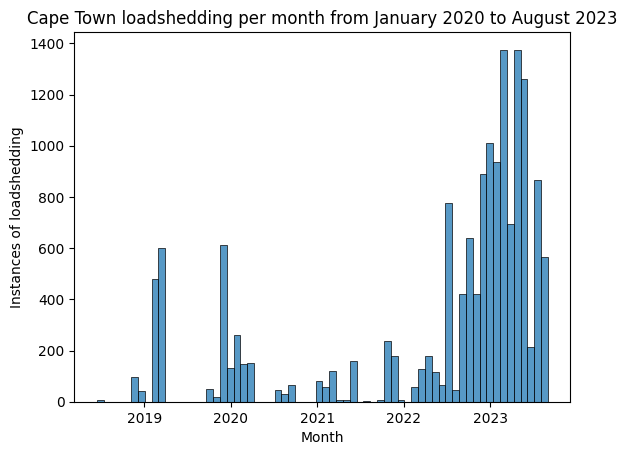

In [4]:
sns.histplot(loadshedding["Start"])
plt.ylabel("Instances of loadshedding")
plt.xlabel("Month")
plt.title("Cape Town loadshedding per month from January 2020 to August 2023")
plt.show()

## Is loadshedding effective in reducing electricity consumption and peak load?

The [purpose of loadshedding](https://en.wikipedia.org/wiki/South_African_energy_crisis#Loadshedding) is to reduce instantaneous load on the national grid, with each stage representing a reduction of 1000 MW. Using a data set of the electricity load profile of Cape Town, we investigate whether or not loadshedding is effective in its purpose.

The following cell imports, structures and converts the Cape Town electricity load data set. This includes electrical demand readings of apparent power (MVA) or current (amperes), measured every 30 minutes at each of the intake points. The time-series data span 2015 to 2021. Note that the City of Cape Town reports that Koeberg Road became Maitland and that Owen and Ikapa were added to Gugulethu.

In [5]:
suburb_loads = pd.DataFrame()
# read in the data for each of the instake points (suburbs)
for path in sorted(glob('../data/load/*.csv')):
    suburb = Path(path).stem
    # fix the column headings
    suburb_load = pd.read_csv(path, skiprows=[1, 2])
    suburb_load.rename(columns={'Unnamed: 0': 'Timestamp'}, inplace=True)
    if "Timestamp" not in suburb_loads.columns:
        suburb_loads["Timestamp"] = pd.to_datetime(suburb_load["Timestamp"])
    # convert kVA and Amps to MVA
    if "MVA" not in suburb_load.columns:
        if "kVA" in suburb_load.columns:
            if suburb_load["kVA"].dtype == "object":
                suburb_load["kVA"] = suburb_load["kVA"].str.replace(",", "").astype(float)
            suburb_load["MVA"] = suburb_load["kVA"] / 1000
        elif "Amps" in suburb_load.columns:
            suburb_load["MVA"] = suburb_load["Amps"] * 11600 / 10**6
        else:
            raise ValueError(f"Cannot calculate MVA column for {suburb}.")
    suburb_loads[suburb] = suburb_load["MVA"]

The loads are then merged based on the loadshedding area of each intake point. This allows the data to be merged with the loadshedding data. The area mappings are defined in `areas.py`.

In [6]:
# merge the load of intake points based on their loadshedding area
areas = {}
for suburb, area in MAPPINGS.items():
    area_name = f"Area {area}"
    if area not in areas:
        areas[area] = pd.DataFrame(suburb_loads["Timestamp"])
        areas[area]["Load"] = suburb_loads[suburb]
    else:
        areas[area]["Load"] += suburb_loads[suburb]

### Per-area peak load

Loadshedding Area 7 is of particular interest, since it encompasses both the Cape Town CBD and some residential areas. Let's consider it in our per-area peak load analysis. Only values from February 2020 onwards are considered, for which we have high-quality loadshedding records. The missing non-loadshedding load values are imputed using last-(non-loadshedding)-value-carried-forwards, which is standard practice for time-series data with few missing values.  

In [7]:
def is_loadshedding(area_loadshedding, timestamp) -> bool:
    """Returns whether or not the specified timestamp is within a loadshedding instance."""
    return max((area_loadshedding["Start"] <= timestamp) & (area_loadshedding["End"] >= timestamp))

area = 7
area_load = areas[area]
# discard values for which we don't have consistent loadshedding data
area_load = area_load[area_load.Timestamp >= pd.to_datetime("2020/2/1")].copy()
area_loadshedding = loadshedding[loadshedding.Area == f"Area {area}"]
area_load["Loadshedding"] = area_load["Timestamp"].apply(partial(is_loadshedding, area_loadshedding))
area_load["Restored"] = area_load.Loadshedding.shift(1) & ~area_load.Loadshedding
# impute missing non-loadshedding load values using last-value-carried-forwards
area_load.loc[~area_load.Loadshedding, "Load"] = area_load.loc[~area_load.Loadshedding, "Load"].ffill()

Comparing the mean load when not loadshedding with that of the 30 minutes after instances of loadshedding, the mean load directly after loadshedding is 14.27% greater. This result is perhaps intuitive; during loadshedding, fridges become warm, geysers become cold and UPS batteries are depleted. These all need to be rectified once the power returns. This causes a surge of demand, which can damage grid infrustructure. 

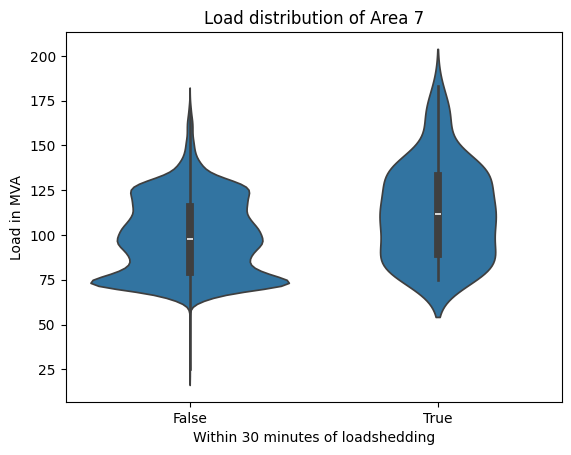

In [8]:
area_load_not_loadshedding = area_load[~area_load.Loadshedding]
ax = sns.violinplot(area_load_not_loadshedding, x="Restored", y="Load")
plt.title("Load distribution of Area 7")
plt.ylabel("Load in MVA")
plt.xlabel("Within 30 minutes of loadshedding")
plt.show()

[T-tests](https://en.wikipedia.org/wiki/Student's_t-test) are used to compare the means of two groups and determine if they are significantly different (statistically speaking). Let us use it to compare the mean per-area peak load of days with loadshedding ($\mu_l$) to that of days without loadshedding ($\mu_n$). First, a null (H$_0$) and alternative (H$_a$) hypothesis are defined.

H$_0$: $\mu_l \le \mu_n$<br>
H$_a$: $\mu_l > \mu_n$

Next, a level of significance is chosen—0.05 in this case. We can then conduct a T-test by calculating the test statistic, using the [ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) function of SciPy. Since the p-value of the level of significance, we reject the null hypothesis and accept the alternative hypothesis. Therefore, instead of reducing peak load, loadshedding increased peak load in Area 7 from 2020 to 2023.

In [9]:
area_load_daily_max = area_load.groupby(pd.Grouper(key="Timestamp", freq="d")).max()
a = area_load_daily_max[area_load_daily_max.Loadshedding].Load
b = area_load_daily_max[~area_load_daily_max.Loadshedding].Load
ttest_ind(a, b, equal_var=False, alternative="greater")

TtestResult(statistic=6.616965212144658, pvalue=1.1001660391236885e-09, df=94.4130936682952)

### Peak load

Let's compare the mean peak load of the entirety of Cape Town on days with loadshedding to days without loadshedding. To do so, we need to calculate the total load by merging the constituent loadshedding area DataFrames.

In [10]:
# merge the area load DataFrames to calculate the total load of Cape Town
total_load = None
for area_load in areas.values():
    area_load = area_load.ffill()
    if total_load is None:
        total_load = area_load.copy()
    else:
        total_load["Load"] += area_load["Load"]
total_load = total_load[total_load.Timestamp >= pd.to_datetime("2020/2/1")]
total_load["Loadshedding"] = total_load["Timestamp"].apply(partial(is_loadshedding, loadshedding))

We conduct another T-test with significance level 0.05 and the hypotheses defined below.

H$_0$: The mean peak load in Cape Town on days with loadshedding is equal to days without.<br>
H$_a$: The mean peak load in Cape Town on days with loadshedding is not equal to days without.

With a calculated p-value of 0.07, we fail to reject the null hypothsis that the means are equal. We therefore conclude that loadshedding has not significantly reduced peak load in Cape Town from 2020 to 2023.

In [11]:
total_load_daily_max = total_load.groupby(pd.Grouper(key="Timestamp", freq="d")).max()
a = total_load_daily_max[total_load_daily_max.Loadshedding].Load
b = total_load_daily_max[~total_load_daily_max.Loadshedding].Load
ttest_ind(a, b, equal_var=False, alternative="two-sided")

TtestResult(statistic=-1.8462081598050317, pvalue=0.06655447941763017, df=174.65278166795534)

### Consumption

Monthly billing can be used as a proxy for monthly consumption, bearing in mind the fluctuations in electricity price. The code cells below import the Cape Town monthly billing data (available from 2019 to 2022), extract the total for each month and plot the data. The total monthly billing is noisy, but shows a definite trend in line with the rising eletricity price. In 2022, Cape Town routinely spent more than a billion Rand per month on electricity.

In [12]:
# extract the total amounts from the monthly eletricity billing of Cape Town
total_amounts = []
months = []
month_names = []
for path in sorted(glob('../data/billing/*.csv')):
    df = pd.read_csv(path, delimiter=";")
    total_amount = df[df.Location == "Result"]["Amount"].values[0]
    total_amount = total_amount.replace(",", ".")
    total_amount = total_amount.replace(" ", "")
    total_amount = float(total_amount)
    total_amounts.append(total_amount)
    month_name = Path(path).stem
    months.append(pd.to_datetime(month_name))
    month_names.append(month_name)
# calculate the 5-month moving average
total_amount_moving_avg = pd.Series(total_amounts).rolling(5).mean().shift(-2)

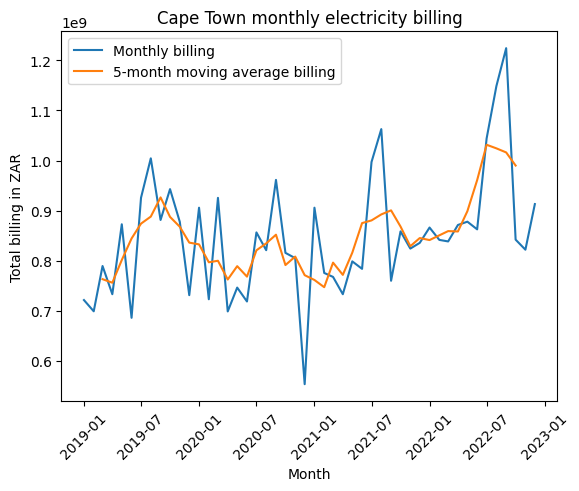

In [13]:
sns.lineplot(x=months, y=total_amounts, label="Monthly billing")
sns.lineplot(x=months, y=total_amount_moving_avg, label="5-month moving average billing")
plt.xticks(rotation=45)
plt.title("Cape Town monthly electricity billing")
plt.xlabel("Month")
plt.ylabel("Total billing in ZAR")
plt.show()

Plotting the billing and loadshedding data, there is no meaningful correlation between loadshedding-minutes and electricity expenditure per month in Cape Town. The slightly positive correlation can be attributed to the simultaneous increase in loadshedding and electricity cost in recent months. If loadshedding was effective in reducing electricity consumption, we would expect to find a negative correlation in the plot.

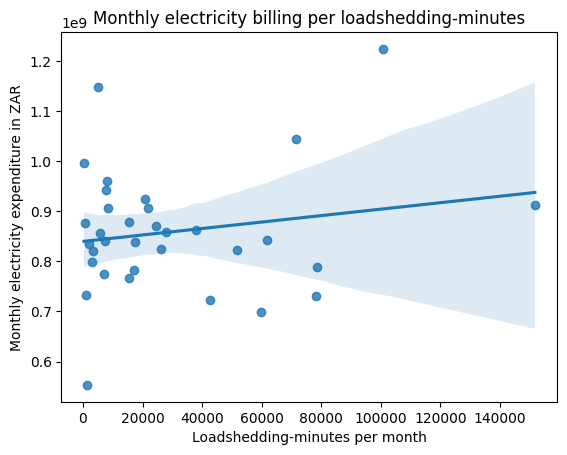

In [14]:
loadshedding['YearMonth'] = pd.to_datetime(loadshedding['Start']).apply(
    lambda x: '{year}-{month}'.format(year=x.year, month=x.month))
loadshedding_and_billing = pd.DataFrame(loadshedding.groupby("YearMonth")["Minutes"].sum())
loadshedding_and_billing.index = pd.to_datetime(loadshedding_and_billing.index)
loadshedding_and_billing = loadshedding_and_billing.join(pd.Series(total_amounts,
                                                                   index=pd.to_datetime(month_names),
                                                                   name="billing"), how="inner")
sns.regplot(loadshedding_and_billing, x="Minutes", y="billing")
plt.title("Monthly electricity billing per loadshedding-minutes")
plt.xlabel("Loadshedding-minutes per month")
plt.ylabel("Monthly electricity expenditure in ZAR")
plt.show()

We have seen that loadshedding is ineffectual in its purpose of reducing peak load; even increasing per-area peak load. Furthermore, it appears that loadshedding does not reduce monthly electricity consumption. 

## Is there a correlation between loadshedding and heightened rates of crime?

Let's now explore the impact of loadshedding on recorded instances of crime across a subset of Cape Town suburbs.\
The crime data was compiled from quarterly crime statistics published by the South African Police Service (SAPS),
and is used to create estimates of the total quarterly loadshedding durations experienced by each suburb.

The estimates are created using spatial data for both the Cape Town loadshedding zones and regions of police station jurisdiction, which mostly correspond to suburbs.

In [15]:
# Import the crime and loadshedding zone data
df_zones = gpd.read_file('../data/loadshedding/Load_shedding_Blocks.geojson')
df_crime = pd.read_csv('../data/crime_statistics_for_south_africa/SAPS_data/all_SAPS_data.csv')
df_stations = gpd.read_file('../data/crime_statistics_for_south_africa/station_shapes/station_boundaries/Police_bounds.shp')
df_station_pts = gpd.read_file('../data/crime_statistics_for_south_africa/station_shapes/station_points/Police_points.shp')
df_loadshedding = pd.read_csv("../data/loadshedding/cape_town.csv", delimiter=';')
df_loadshedding.rename(columns={"Area ": "Area"}, inplace=True)

# Filter out Western Cape police station polygons which are not suburbs of Cape Town
df_CT_stations = df_stations[df_stations['COMPNT_NM'].isin(df_crime['police_station'].unique())]
df_CT_station_pts = df_station_pts[df_station_pts['COMPNT_NM'].isin(df_crime['police_station'].unique())]
max_lat = -33.4
max_lon = 19.5
min_lat = 18
df_CT_stations = df_CT_stations[(df_CT_stations['geometry'].bounds['maxy'] <= max_lat) & (df_CT_stations['geometry'].bounds['maxx'] <= max_lon) &
                                (df_CT_stations['geometry'].bounds['minx'] >= min_lat)]
df_CT_station_pts = df_CT_station_pts[(df_CT_station_pts['geometry'].bounds['maxy'] <= max_lat) & (df_CT_station_pts['geometry'].bounds['maxx'] <= max_lon) &
                                (df_CT_station_pts['geometry'].bounds['minx'] >= min_lat)]

In [16]:
# Calculate the suburb-loadshedding zone mapping and weights
warnings.filterwarnings('ignore')
mappings = []
for index, row in df_CT_stations.iterrows():
    station_polygon = row['geometry']
    if not station_polygon.is_valid:
        station_polygon = station_polygon.buffer(0)
    overlapping_polygons = []
    overlapping_areas = []

    for index2, row2 in df_zones.iterrows():
        zone_polygon = row2['geometry']
        if not zone_polygon.is_valid:
            zone_polygon = zone_polygon.buffer(0)
        intersection = station_polygon.intersection(zone_polygon)
        if intersection:
            overlapping_polygons.append(row2["BlockID"])
            overlapping_areas.append(intersection.area / row["geometry"].area)
    if overlapping_polygons:
        mappings.append((row["COMPNT_NM"], overlapping_polygons, overlapping_areas))
warnings.filterwarnings('default')

# Remove areas not sufficiently accounted for by the CT loadshedding zones
suburbs = [s[0] for s in mappings]
mappings = [m for m in mappings if np.sum(m[2]) > 0.8]
df_CT_stations = df_CT_stations[df_CT_stations["COMPNT_NM"].isin(suburbs)]

In [17]:
# Example output: (Suburb, Loadshedding zone(s), zone weights)
mappings[0]

('RONDEBOSCH',
 [5, 12, 15],
 [0.7498954944645393, 0.017110037920258725, 0.23299456429525567])

Let's create a weighted sum of the quarterly loadshedding times for each suburb, where the weights are defined as the proportions of the loadshedding zone areas with respect to the associated suburb area.\
This accounts for suburbs whose total areas are subsumed by more than one loadshedding zone. 

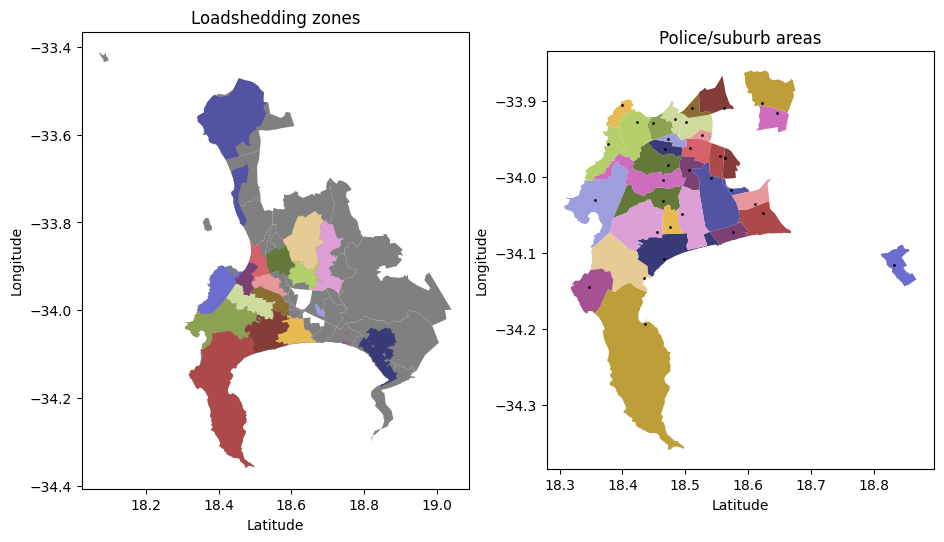

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 14))
df_CT_stations.to_crs(df_zones.crs).plot(ax=ax1, color='grey')
df_zones.plot(ax=ax1, cmap='tab20b')
mappings = [m for m in mappings if np.sum(m[2]) > 0.8]
suburbs = [s[0] for s in mappings]
df_CT_stations = df_CT_stations[df_CT_stations["COMPNT_NM"].isin(suburbs)]
df_CT_stations.to_crs(df_zones.crs).plot(ax=ax2, cmap='tab20b')
for idx, row in df_CT_station_pts.iterrows():
    point = row['geometry']
    pt = (point.x, point.y)
    if df_CT_stations.contains(point).any():
        ax2.scatter(pt[0], pt[1], c='black', s=1)
plt.axes(ax1)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Loadshedding zones")
plt.axes(ax2)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Police/suburb areas")
plt.show()

In [19]:
# Prepare loadshedding data and associate entries with quarterly  periods
df_loadshedding = crime_utils.process_loadshedding_data(df_loadshedding, df_crime)
# Create quarterly loadshedding time estimates 
all_suburb_estimates = crime_utils.get_suburb_loadshedding_estimates(df_loadshedding, mappings) 

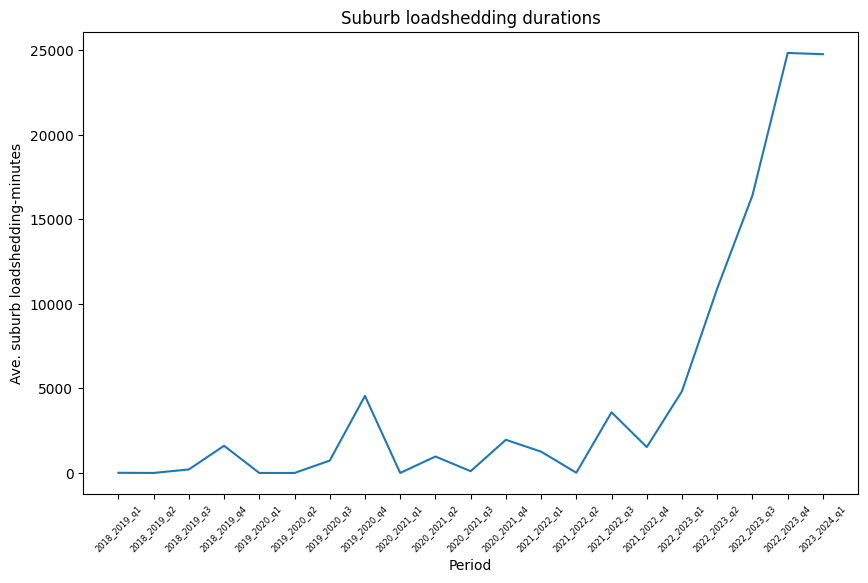

In [20]:
mean_load = [np.mean(list(all_suburb_estimates[q].values())) for q in all_suburb_estimates.keys()]
plt.figure(figsize=(10,6))
plt.plot(mean_load)
plt.xticks(ticks=range(len(all_suburb_estimates.keys())), labels=all_suburb_estimates.keys(), fontsize=6, rotation=45)
plt.xlabel("Period")
plt.ylabel("Ave. suburb loadshedding-minutes")
plt.title("Suburb loadshedding durations")
plt.show()

Correlation Coefficient: 0.03689873378034507


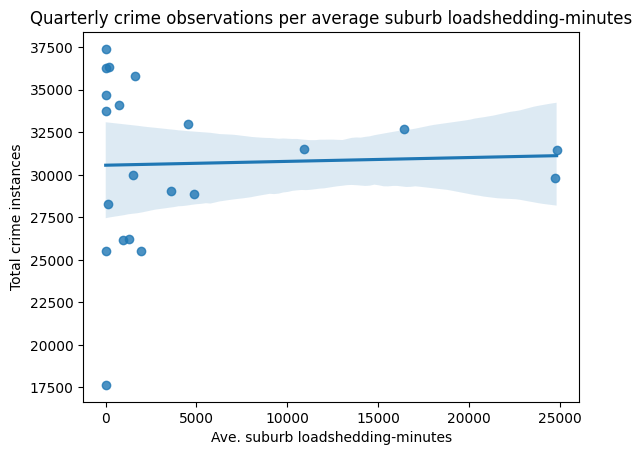

In [21]:
df_crime_CT = df_crime[df_crime["police_station"].isin(suburbs)]
df_crime_CT = df_crime_CT[["type"] + list(all_suburb_estimates.keys())]
total_crime = df_crime_CT.groupby("type").sum().values
total_crime = np.sum(total_crime, axis=0)
corr = pd.concat([pd.DataFrame(total_crime), (pd.Series(mean_load))], axis=1)
corr.columns = ["Total crime instances", "Ave. suburb loadshedding-minutes"]
sns.regplot(corr, x="Ave. suburb loadshedding-minutes", y="Total crime instances")
plt.title("Quarterly crime observations per average suburb loadshedding-minutes")
coeff, p_value = pearsonr(total_crime, mean_load)
print("Correlation Coefficient:", coeff)

The above graph indicates that there is a negligible correlation between loadshedding and total across-the-board crime.\
This is expected, given that there is no intuitive relationship between loadshedding and most forms of crime.

In particular, we are interested in observing conceivable relationships between loadshedding and crimes such as vandalism, burglaries, and theft.

We observe that loadshedding experienced a significant increase from 2022 onwards, so let's split the data into crime before 2022 and crime afterwards. 
For each crime type, we'll perform a t-test with a significance level of $\alpha=0.05$ to see if the mean number of crime incidents after 2022 is greater than before the period of heavy loadshedding began.

The null and alternative hypotheses are defined as follows:

$H_{0}$: The means for both samples are equal.\
$H_{a}$: The mean of the sample corresponding to heavy loadshedding is greater than the mean of the sample corresponding to light loadshedding.


In [22]:
crime_types = ["Burglary at residential premises", "Burglary at non-residential premises", "Robbery at residential premises",
               "Robbery at non-residential premises", "Malicious damage to property"]
t_test_results = []
for crime_type in crime_types:
    total_crime = df_crime_CT.groupby("type").sum()
    total_crime
    crime_instances = total_crime.loc[crime_type].to_numpy()
    len_crime_instances = len(crime_instances)
    pre_2022 = np.array(crime_instances[:(len_crime_instances - 5)])
    from_2022 = np.array(crime_instances[(len_crime_instances - 5): len_crime_instances])
    _, p_value = ttest_ind_from_stats(pre_2022.mean(), pre_2022.std(), len(pre_2022), from_2022.mean(), from_2022.std(), len(from_2022), alternative='less')
    t_test_results.append([crime_type, p_value, p_value < 0.05])
pd.DataFrame(t_test_results, columns=["Crime type", "p-value", "H0 is rejected (a=0.05)"])

,Crime type,p-value,H0 is rejected (a=0.05)
0,Burglary at residential premises,0.908369,False
1,Burglary at non-residential premises,0.986288,False
2,Robbery at residential premises,0.988021,False
3,Robbery at non-residential premises,0.963881,False
4,Malicious damage to property,0.380949,False


Although it may seem intuitive that burglaries, robberies, and vandalism should increase with overall loadshedding durations, these outcomes are unfounded in the data.\
A possible explanation could be that criminals would still probably be deterred to inact these crimes during broad daylight, irrespective of whether there's loadshedding or not. At night, loadshedding may also prevent burglars/robbers from profiling un-lit houses as viable targets, as opposed to any contrasting well-lit neighbouring houses.\
It is also possible to argue that some individuals may be more cautious or vigilant during periods of nightly loadshedding, or that criminals might be aware of the possibility for alarm systems to remain operational on battery power during power outages.

The results for malicious property damage are slightly harder to explain, especially given the surplus of stories involving harm levied at substations.\
It is possible that the analysed data may not account for many of these instances, or that our perceptions of the effective prevalence of these crimes is significantly distorted by media.
 

In [23]:
crime_corrs = []
for crime_type in df_crime_CT["type"].unique():
    crime = df_crime_CT[df_crime_CT["type"] == crime_type].groupby("type").sum().values[0]
    coeff, p_value = pearsonr(crime, mean_load)
    crime_corrs.append([crime_type, coeff])
result = pd.DataFrame(crime_corrs, columns=["Crime Type", "Correlation coefficient"]).sort_values("Correlation coefficient", ascending=False).reset_index(drop=True)
result.head(3)

,Crime Type,Correlation coefficient
0,Commercial crime,0.747296
1,Attempted sexual offences,0.564336
2,Common assault,0.317969


Commercial crimes refer to non-violent financial crimes. E.g., tax fraud.\
It may not be immediately obvious why we might observe a moderate to strong positive correlation between loadshedding and commercial crimes, but according to [this article](https://link-url-here.org), Santam reported in its 2022/2023 Insurance Barometer report that there has been a significant uptick in power surge-related claims fraud.

Although the exact nature of these crimes are unknown, it is possible that the increasing prevalence of observed commercial crimes might corroborate the claim described in the article.

The moderate positive correlation between loadshedding and attempted sexual offences can perhaps be attributed to the increased vulnerability of certain individuals at times of the day when visibility is poor. The removal of public light sources, like street lamps, can make it difficult to detect potential criminal threats and take pre-emptive or evasive actions.

***

## Do higher levels of loadshedding lead to higher mortality rates?

To gain insight for this question, we can calculate the correlation between the highest stage of loadshedding and the death rate for each day in 2018.
After that we can test the hypothesis that the mean death rate is higher on days with loadshedding than it is on days without it.

Let's start by preprocessing the data.

### Preprocessing

We're using two datasets that don't overlap well and appear to have missing data, so let's filter and combine so that they're easier to analyse.

In [24]:
data_dir = "../data"
death_counts = mortality_utils.load_daily_death_counts(data_dir)
# Only keep the data for 2018. The other years appear to be missing a lot of data.
death_counts = death_counts.query("year == 2018")
# Load and prepare loadshedding and population data sets, so that we can investigate the relationship between mortality and loadshedding.
loadshed_stages = mortality_utils.load_and_sort_stages(data_dir)
population_df = mortality_utils.load_and_prep_population_df(data_dir)
# Compute the death rates so that changes in population size do not impact our analysis.
death_counts = mortality_utils.update_with_death_rates(death_counts.copy(), population_df)
# Find the maximum stage of loadshedding for each day so that we  have an estimate of the severity of loadshedding on that day, which we can try to correlate with the death rate.
daily_max_stage = mortality_utils.compute_max_stage_per_day(loadshed_stages)
# Combine death counts and loadshedding stage for each day. Use a 'left' merge so that days without loadshedding are accounted for.
deaths_and_max_stage = pd.merge(death_counts,daily_max_stage,how="left",on="date")
# Fill missing loadshedding stages with zeros to indicate no loadshedding on that day.
deaths_and_max_stage["stage"] = deaths_and_max_stage["stage"].fillna(0)

### Correlation between severity of loadshedding and death rate

Now that our data is ready, we can observe the correlation between the death rate and the severity of loadshedding.
We can use the code below to produce the Pearson correlation coefficient and visualise a linear regression between the variables.

Pearson correlation: 0.16


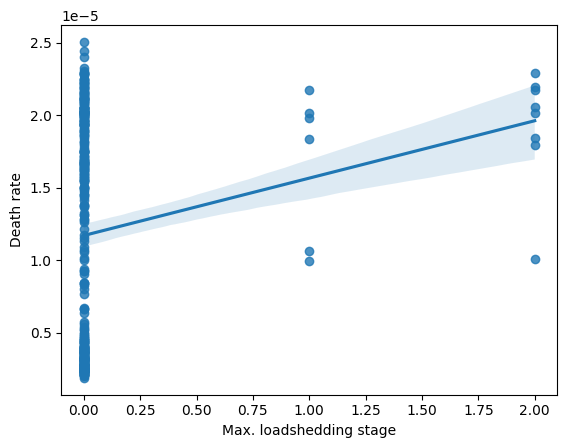

In [25]:
sns.regplot(
    x=deaths_and_max_stage["stage"].rename('Max. loadshedding stage'),
    y=deaths_and_max_stage["death_rate"].rename('Death rate'),
)
corr = deaths_and_max_stage[["death_rate", "stage"]].corr(method='pearson')['death_rate']['stage']
print(f'Pearson correlation: {corr:.2f}')

The correlation is fairly small at $0.16$.
The linear regression and scatter plot shows that minimum death rate on days with loadshedding is higher than it is on days without loadshedding.
Together, these results show that the death rate tends to be higher on days with loadshedding.
However, the relationship appears to be quite weak.


### Hypothesis test

We've seen that the death rate is slightly positively correlated with the severity of loadshedding.
For further insight, let's test the hypothesis that the mean death rate is larger on days with loadshedding.

In [26]:
def check_for_equal_variance(a, b):
    _, pval = levene(a["death_rate"], b["death_rate"])
    return pval >= 0.05

    
def test_death_rate_hypothesis(deaths_and_ls_stage):
    # Separate entries with and without loadshedding so we can test our hypothesis
    deaths_with_loadshedding = deaths_and_ls_stage.query("stage > 0")
    deaths_without_loadshedding = deaths_and_ls_stage.query("stage == 0")
    # Check for equal variance to see if we need to use Welch's T-test
    equal_var=check_for_equal_variance(deaths_with_loadshedding, deaths_without_loadshedding)
    # Show whether the variances of the samples are equal so we know how to compute the standard error later on.
    if equal_var:
        print('Samples have equal variance')
    else:
        print('Samples do not have equal variances')
    # Test the hypothesis that the death rate is larger when there is loadshedding.
    return ttest_ind(
        deaths_with_loadshedding["death_rate"],
        deaths_without_loadshedding["death_rate"],
        alternative="greater",
        equal_var=equal_var
    )
ttest_res = test_death_rate_hypothesis(deaths_and_max_stage)
ttest_res

Samples do not have equal variances


TtestResult(statistic=5.036062051579745, pvalue=5.7948698508453296e-05, df=16.263980479087106)

The result shows that at significance level $\alpha=0.05$, the death rate is larger on days with loadshedding.
This is somewhat expected, given the correlation and regression plot that we saw earlier.
Furthermore, our observations are consistent with other, more recent, happenings.
For example, [WWF South Africa](https://www.wwf.org.za/?43942/Compromised-water-availability-and-quality-is-the-hidden-cost-of-loadshedding) report that loadshedding has a severe impact on water quality.
They state that loadshedding can prevent wastewater treatment plants from functioning correctly.
Moreover, they report that sewerage contamination linked to loadshedding recently resulted in beach closures and reduced the quality of rivers and other water sources used for irrigation and recreation.
When one considers factors like this, it is not difficult to imagine how loadshedding could lead to more deaths.

### How many lives were lost due to loadshedding? (assuming our data is reliable, and that loadshedding has a causal effect)

Assuming our data accurately reflect the trend in mortality in 2018, our results show that loadshedding is associated with increased mortality.
If we further assume that this association is due to a causal effect of loadshedding on the death rate, then we can estimate the increase due to loadshedding.
However, these assumptions are quite strong, so don't take this too seriously.

The code below estimates the increase to be 15.
That is, without loadshedding in 2018, there would have been 15 fewer deaths per day, on average.
More broadly, it estimates that there would be have been 5475 fewer deaths in total over the course of the year.

In [27]:
# Estimate death count for 2018 using the mean from days without loadshedding. So that we can use this estimate to estimate the deaths due to loadshedding.
estimated_deaths_no_ls = mortality_utils.estimate_deaths_without_loadshedding(deaths_and_max_stage) 
print(
    f"Estimated daily death count for 2018, without loadshedding: {estimated_deaths_no_ls}"
)
observed_deaths = mortality_utils.recalc_deaths(deaths_and_max_stage)
print(f"Observed daily death count for 2018: {observed_deaths}")
diff = math.ceil(observed_deaths - estimated_deaths_no_ls)
print(
    f"Estimated number of lives lost, per day, due to loadshedding: {diff}"
)
print(
    f"Estimated number of lives lost in 2018 due to loadshedding: {diff*365}"
)

Estimated daily death count for 2018, without loadshedding: 671
Observed daily death count for 2018: 686
Estimated number of lives lost, per day, due to loadshedding: 15
Estimated number of lives lost in 2018 due to loadshedding: 5475


## Is South Africa transitioning to renewable energy?

We would hope that all our efforts are worth it, and that the time we're spending without power is at least being rectified in the mean time.
It seems like a good idea for us to examine Cape Town's emission data, and compare it with the energy data. The idea behind this is that we should see that we get to generate more electricity with less greenhouse gas emissions.

We will start by importing the data, ensuring that our data points are all correctly imported as floats, before transposing it to get each sector as a column for a more natural addressing scheme.

In [28]:
# Read in the energys data from the City of Cape Town
emissions_df = pd.read_csv("../data/emissions/Emissions_By_Sector_In_tCO2e.csv",
                             dtype={"2012":float, "2013":float, "2014":float, "2015":float, "2016":float, "2017":float, "2018":float, "2019":float},
                             index_col="Sector")
emissions_df = emissions_df.transpose()
energy_df = pd.read_csv("../data/emissions/Energy_Per_Sector_In_GJ.csv",
                             dtype={"2012":float, "2013":float, "2014":float, "2015":float, "2016":float, "2017":float, "2018":float, "2019":float},
                             index_col="Sector")
energy_df = energy_df.transpose()

# Create a dictionary from emissions columns to energy
# Since we don't want to look at the data for the waste emissions
shared_columns = {}
for col in energy_df:
    if col in emissions_df:
        shared_columns[col] = col
# These two columns aren't shared in the two input files
shared_columns["Total energy-related (excl. aviation & marine)"] = "Total (excl. aviation & marine)"
shared_columns["Total energy-related"] = "Total"

To verify the usability of the data, we can first plot each of the sector's results for some EDA to make sure the data isn't complete garbage.
Any spikes and dips that look suspicious will be highlighted in our yearly data.

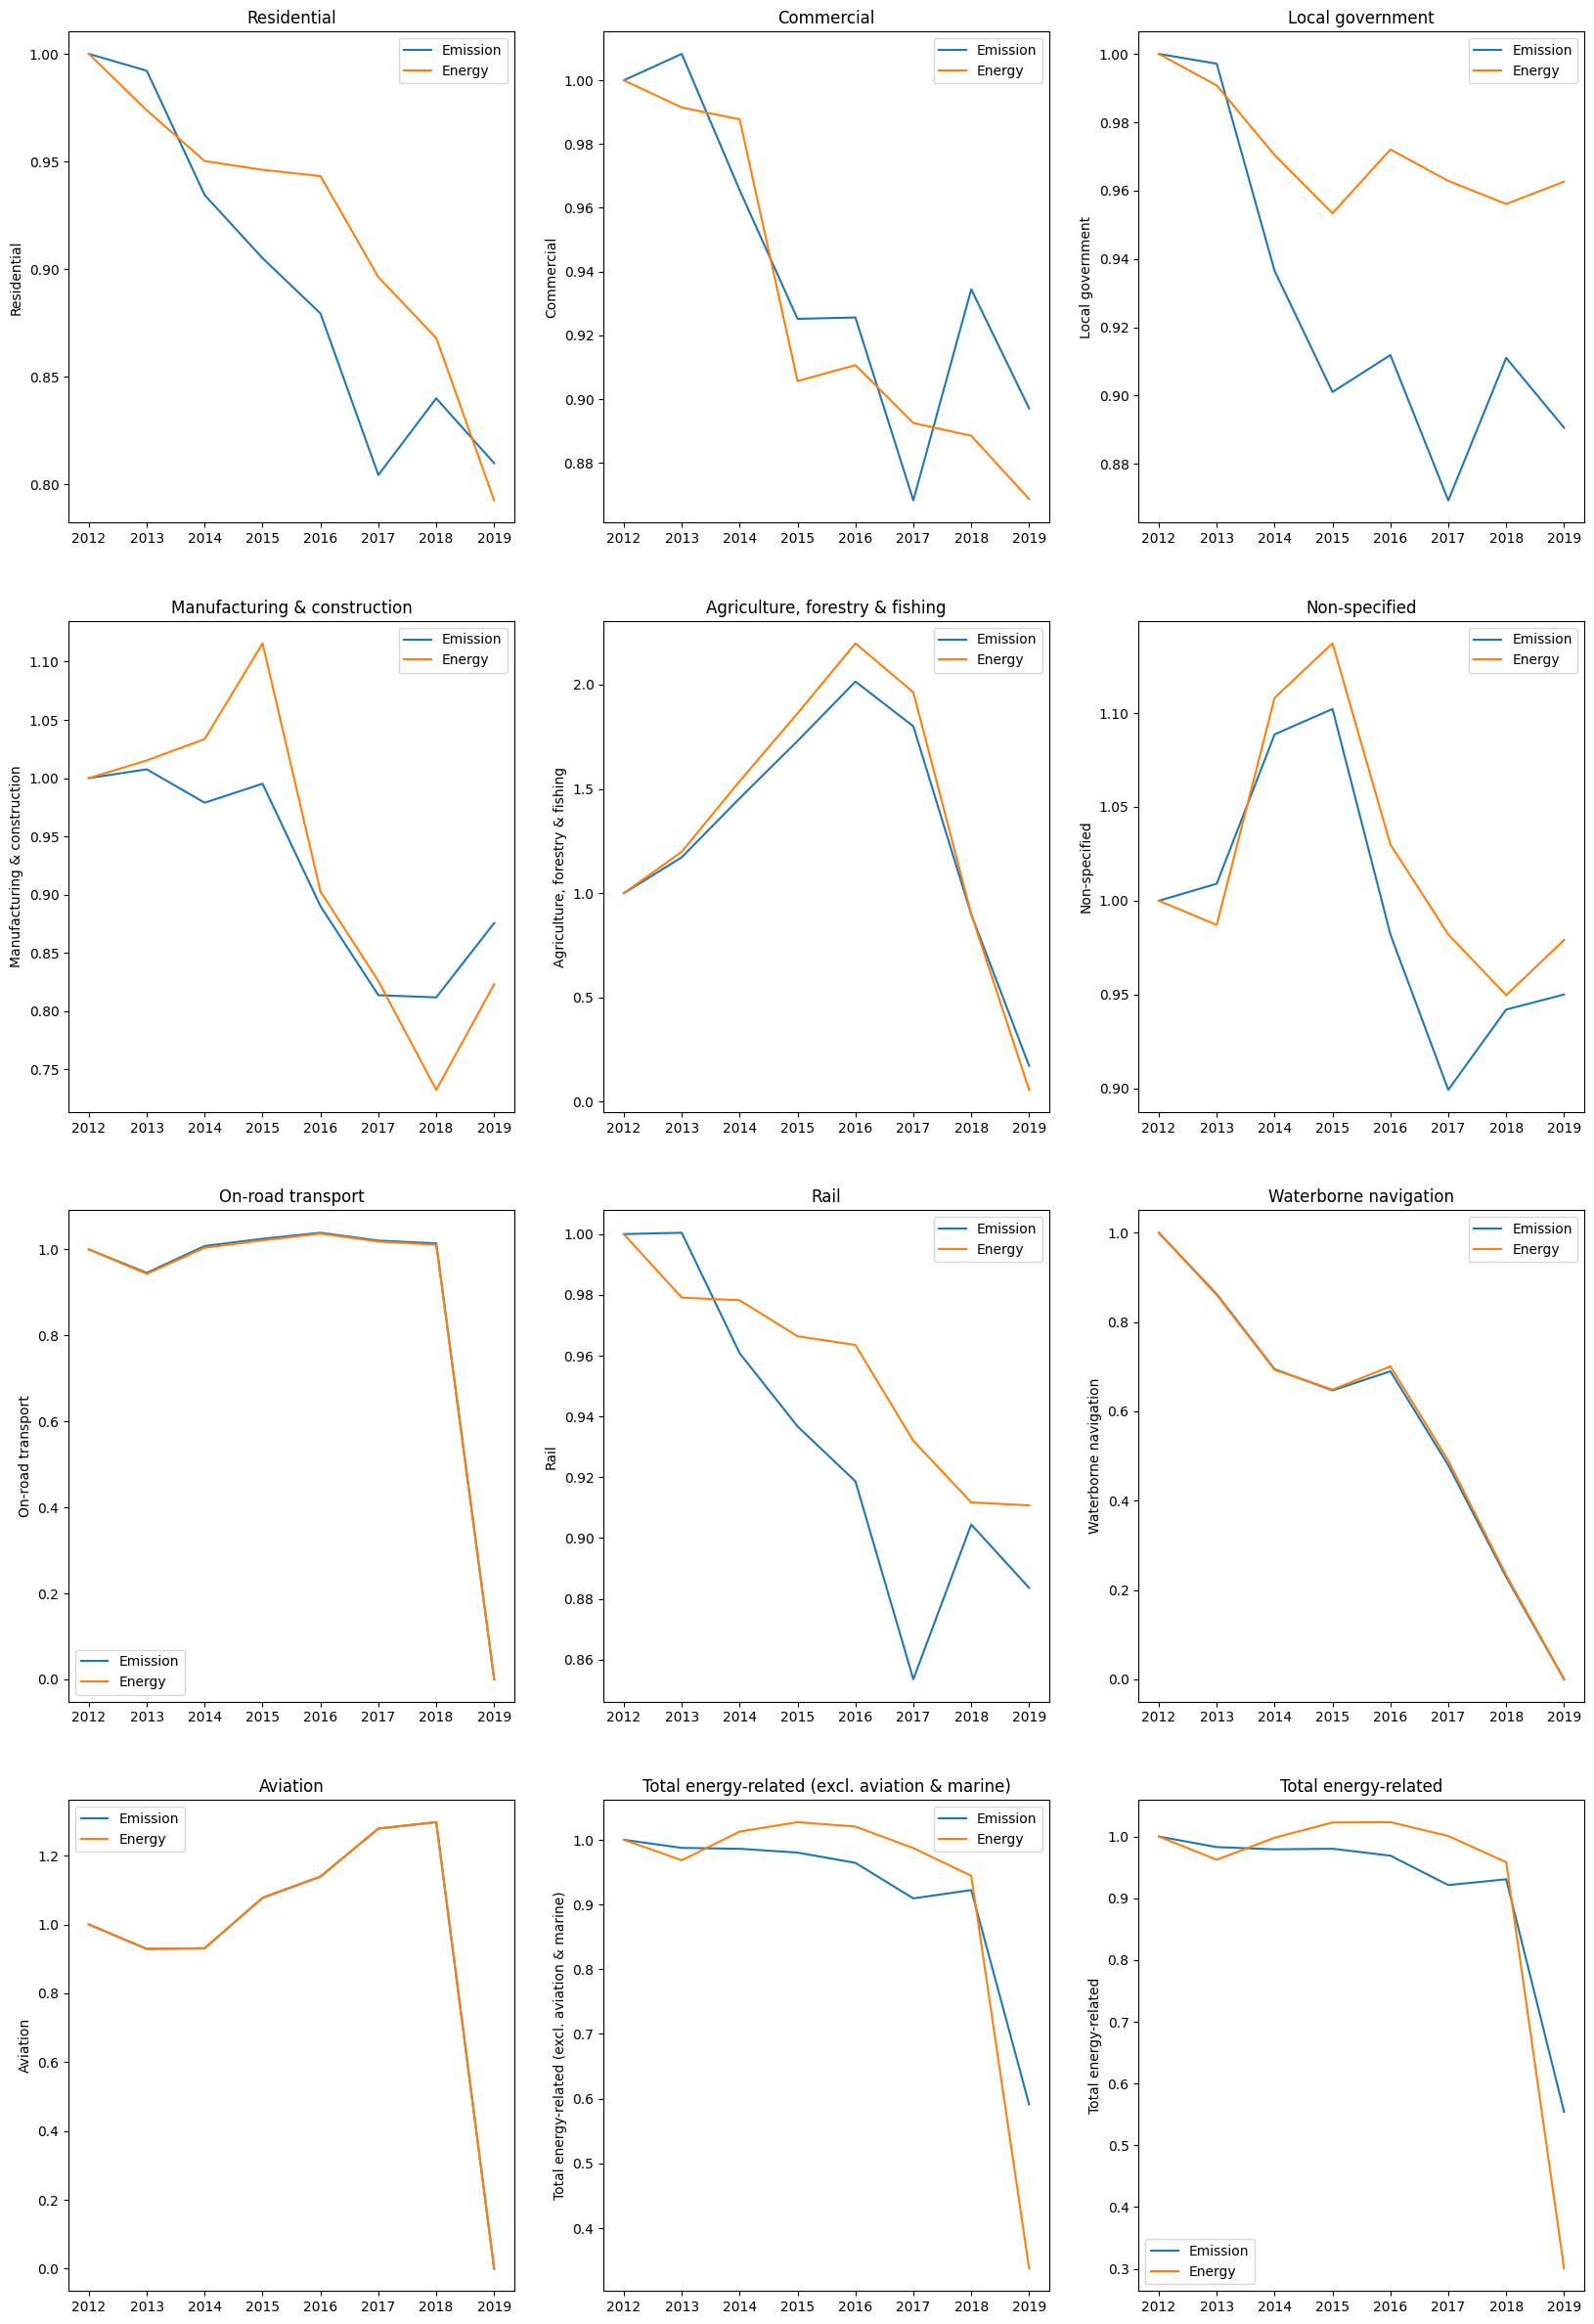

In [29]:
warnings.filterwarnings('ignore')
# Create a 4x3 subplot and flatten the axes so I can refer to them in 1 dimension
fig, ax = plt.subplots(4, 3, figsize=(20,30))
ax = ax.flatten()
plot_no = 0

for col in shared_columns:
    emission_col, energy_col = col, shared_columns[col]
    # We normalise each data by dividing their value with their 2012 value as a baseline
    # To make it comparable and highlight any large differences
    emission_data = emissions_df[emission_col]/emissions_df[emission_col][0]
    sns.lineplot(emission_data, label="Emission", ax=ax[plot_no])
    energy_data = energy_df[energy_col]/energy_df[energy_col][0]
    sns.lineplot(energy_data, label="Energy", ax=ax[plot_no])


    ax[plot_no].set_title(col)
    plot_no += 1
warnings.filterwarnings('default')

We see that road, sea and air transport's emission and energy percentage is basically perfectly correlated, so it's quite clear that the one calculates the other. In addition, there's a sharp dropoff for aviation and road transport to basically 0 in 2019.

It's clear that our data does in fact not have reliable entries for 2019.
Therefore, we should be very careful about using the data from that year to make any sort of assumptions.

## Energy and Emissions
Since we're looking into a correlation of emissions and energy, it would be a good idea to see if our emissions are reduced while keeping the energy approximately the same. To check this, we would use a linear correlation test for two continuous variables, which we can do with [Pearson's Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).

Naturally, we must remember to state our hypothesis test, using $\alpha = 0.05$:

$H_{0}$: The values are uncorrelated and normally distributed.

$H_{a}$: The values correlated and possibly not normally distributed.

PearsonRResult(statistic=0.48249967836782176, pvalue=0.13640094897832108)
We do not reject the null hypothesis


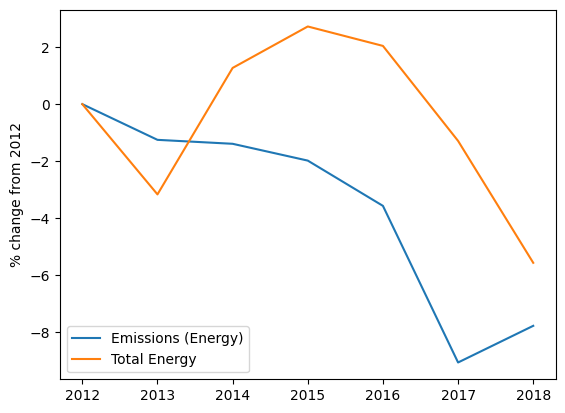

In [30]:
warnings.filterwarnings('ignore')
# Set the alpha value that we use for the p-value to be able to reject or accept with a 5% significance level
a = 0.05
# We use the greater alternative to attempt to show positive correlation: Both values moving in unison
res = pearsonr(emissions_df["Total energy-related (excl. aviation & marine)"][:-1],
               energy_df["Total (excl. aviation & marine)"][:-1],
               alternative="greater")
print(res)
if (res.pvalue < a):
    print("We reject the null hypothesis")
else:
    print("We do not reject the null hypothesis")

# Create the plot to show the percentage change since 2012
emission_percent_from_2012 = (emissions_df["Total energy-related (excl. aviation & marine)"][:-1]/emissions_df["Total energy-related (excl. aviation & marine)"][0] - 1) * 100
energy_percent_from_2012 = (energy_df["Total (excl. aviation & marine)"][:-1]/energy_df["Total (excl. aviation & marine)"][0] - 1) * 100
sns.lineplot(emission_percent_from_2012, label="Emissions (Energy)")
sns.lineplot(energy_percent_from_2012, label="Total Energy")
plt.ylabel("% change from 2012")
plt.show()
warnings.filterwarnings('default')

We have not rejected the null hypothesis, as there isn't enough evidence to show that energy and emissions are linearly correlated, given the size of our sample (Which is very small for a correlation test, with only one entry for each of the 7 years).

Because of this, we could make an assumption that it's not just because of reduced electricity use that our emissions have improved.
This could imply that renewables are contributing to the power being generated, but this assumes a lot about the data. 

If we look at the original data, we can see in their sources that the emissions data is based on the electricity demand multiplied by an emission factor which we have no insight into how it was calculated.

Let's turn our attention to residential data, to see if we can get other interesting results; perhaps solar installations by residences have proved to be a positive impact.

PearsonRResult(statistic=0.8601424319689075, pvalue=0.0061417765890476985)
We reject the null hypothesis


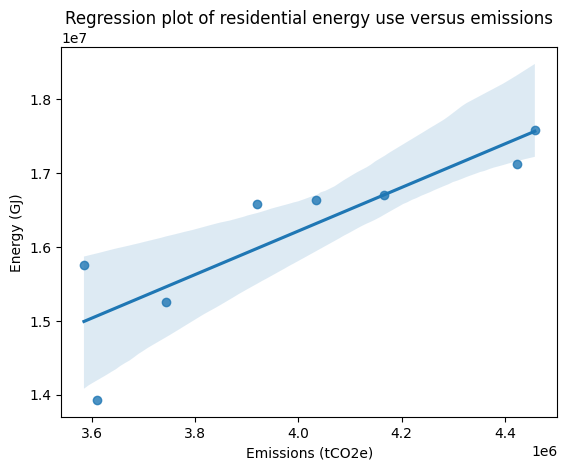

In [31]:
res = pearsonr(emissions_df["Residential"], energy_df["Residential"])
print(res)
if (res.pvalue < a):
    print("We reject the null hypothesis")
else:
    print("We do not reject the null hypothesis")

# Show a regression plot to highlight the correlation.
sns.regplot(x=emissions_df["Residential"],
             y=energy_df["Residential"])
plt.xlabel("Emissions (tCO2e)")
plt.ylabel("Energy (GJ)")
plt.title("Regression plot of residential energy use versus emissions")
plt.show()

For residential emissions, we can see that these values are correlated, hinting at a strong dependency between Emissions and Energy use. However, again, we are required to confront the origins of our data, as electrial emmissions data requires supply from Eskom, which we don't get if residential units are using their own generated power.

Thus, given our data set, we must say there is no evidence for improved quality of emissions, only because we do not know how much electricity is actually being used in everyone's homes.

In the end though, our data struggles to provide effective conclusions to our hypotheses, and show the strength of finding good data.

## Conclusion

We hope that we enlightened you with our work on various loadshedding related questions, and set your mind to rest on some interesting topics. 

The purpose of loadshedding is to reduce load on the South African electricity grid.
We have seen that loadshedding does not significantly reduce peak load in Cape Town and even increases per-area peak load.
Using billing as a proxy for consumption, we found that loadshedding does not even reduce monthly electricity consumption.
We conclude that loadshedding does not work.

It is also conceivable that other externalities might arise from loadshedding, for example increases in crime rates.
Our analysis revealed that this is not the case for most forms of crime, and that those whose rates did increase with loadshedding are mostly types of fraudulent crimes.
A moderate correlation between loadshedding and contact sexual offenses was also observed, and it was surmised that loadshedding may have an exacerbating effect on the vulnerability of certain individuals, especially in precarious public areas when it is dark.

Beyond this, our exploration of mortality and loadshedding in 2018 showed us that loadshedding _may_ increase the death rate.
We only found an association; however, with recent reports of loadshedding induced health hazards, it would be beneficial to investigate further.
More recent data could show an even stronger effect, and a more rigorous analysis could establish a causal relationship, especially when one considers the uptick in the severity of loadshedding since 2022.
Moreover, the potential danger of loadshedding paired with its ineffectiveness should motivate further investigation.

In our attempt to look at renewable energy adoption, we learnt about the pitfills of trying to find the right data. For our timeframe of data, we found that emissions and energy use aren't linearly correlated (according to our statistics), which didn't help us draw any conclusions. And the reason for residential areas using less power and emitting less CO2 can't be indentified because Eskom can't get usage statistics for any electricity generated on premises.